In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd '/content/drive/MyDrive/Bioinfo_Project'

/content/drive/MyDrive/Bioinfo_Project


In [6]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

prev_disease = pd.read_csv("df_disease_final_first10.csv", nrows=5)
prev_control = pd.read_csv("df_control_final_first10.csv", nrows=5)

gene_col_d = prev_disease.columns[0]
gene_col_c = prev_control.columns[0]

numeric_cols_d = prev_disease.select_dtypes(include=["number"]).columns.tolist()
numeric_cols_c = prev_control.select_dtypes(include=["number"]).columns.tolist()

print("Disease numeric cols:", len(numeric_cols_d))
print("Control numeric cols:", len(numeric_cols_c))

Disease numeric cols: 8
Control numeric cols: 8


Mean expression per gene for disease

In [8]:
disease_mean = {}

for chunk in pd.read_csv(
    "df_disease_final_first10.csv",
    usecols=[gene_col_d] + numeric_cols_d,
    index_col=gene_col_d,
    chunksize=200_000
):
    m = chunk[numeric_cols_d].mean(axis=1)
    disease_mean.update(m.to_dict())

print("Disease mean genes:", len(disease_mean))

Disease mean genes: 644


Mean expression per gene for control

In [9]:
control_mean = {}

for chunk in pd.read_csv(
    "df_control_final_first10.csv",
    usecols=[gene_col_c] + numeric_cols_c,
    index_col=gene_col_c,
    chunksize=200_000
):
    m = chunk[numeric_cols_c].mean(axis=1)
    control_mean.update(m.to_dict())

print("Control mean genes:", len(control_mean))

Control mean genes: 201


Building disaese signature (Disease Mean - Control Mean)

In [10]:
disease_signature = {}
all_genes = set(disease_mean.keys()).union(set(control_mean.keys()))

for g in all_genes:
    disease_signature[g] = disease_mean.get(g, 0) - control_mean.get(g, 0)

print("Disease signature genes:", len(disease_signature))

Disease signature genes: 644


Load Drug matrix and store each drug by similarity to disaese signature

In [11]:
df_drug = pd.read_csv("top_999_drugs_normalized.csv", index_col=0)
print("Drug shape:", df_drug.shape)

Drug shape: (652, 999)


In [12]:
def score_drug(drug_profile, disease_signature_dict):
    common_genes = list(set(drug_profile.index) & set(disease_signature_dict.keys()))

    if len(common_genes) < 3:
        return np.nan

    x = drug_profile.loc[common_genes].values
    y = np.array([disease_signature_dict[g] for g in common_genes])

    if np.std(x) == 0 or np.std(y) == 0:
        return np.nan

    score, _ = pearsonr(x, y)
    return score


drug_results = []
for drug_col in df_drug.columns:
    score = score_drug(df_drug[drug_col], disease_signature)
    drug_results.append((drug_col, score))

drug_scores_df = pd.DataFrame(drug_results, columns=["Drug", "RestorationScore"])
drug_scores_df = drug_scores_df.sort_values("RestorationScore", ascending=False)

drug_scores_df.head(20)

,Drug,RestorationScore
104,CPC003_PC3_24H:BRD-A49765801-001-03-3:10,0.689200
168,CPC003_VCAP_24H:BRD-K09132007-001-01-8:10,0.684607
6,CPC006_PC3_24H:BRD-K32330832-001-01-0:11.1,0.683879
29,CPC006_MCF7_24H:BRD-K62810658-001-06-4:10,0.681027
214,CPC006_HA1E_24H:BRD-K26664453-001-03-4:10,0.678511
45,CPC001_PC3_6H:BRD-K68620903-001-03-1:10,0.677217
182,CPC003_HCC515_6H:BRD-K01902415-001-03-4:10,0.676088
23,CPC006_HT29_24H:BRD-A93255169-001-13-5:10,0.675734
134,CPC006_MDST8_6H:BRD-K12994359-001-07-7:177.6,0.675666
287,CPC006_HT29_24H:BRD-K93176058-001-02-8:10,0.673218


Score by restoration score descending

In [13]:
top_drugs = drug_scores_df.sort_values(by='RestorationScore', ascending=False).head(999)

top_drugs = top_drugs.reset_index(drop=True)

def parse_drug_name(drug_name):
    parts = drug_name.split(':')
    compound_cell = parts[0]
    well = parts[1] if len(parts) > 1 else ''
    compound, cell_line, time = compound_cell.split('_')
    return compound, cell_line, time, well

top_drugs[['Compound','CellLine','Time','Well']] = top_drugs['Drug'].apply(lambda x: pd.Series(parse_drug_name(x)))

top_drugs = top_drugs[['Compound','CellLine','Time','Well','RestorationScore']]

print(top_drugs)

top_drugs.to_csv('top_drugs.csv', index=False)

print("Results saved to top_drugs.csv")

    Compound CellLine Time                    Well  RestorationScore
0     CPC003      PC3  24H  BRD-A49765801-001-03-3          0.689200
1     CPC003     VCAP  24H  BRD-K09132007-001-01-8          0.684607
2     CPC006      PC3  24H  BRD-K32330832-001-01-0          0.683879
3     CPC006     MCF7  24H  BRD-K62810658-001-06-4          0.681027
4     CPC006     HA1E  24H  BRD-K26664453-001-03-4          0.678511
..       ...      ...  ...                     ...               ...
994   CPC006     HT29  24H  BRD-K00317371-001-02-0         -0.667201
995   CPC002     HA1E   6H  BRD-K96354014-001-08-8         -0.668336
996   CPC005     HT29  24H  BRD-K21936341-051-02-4         -0.668485
997   CPC006    SNUC5   6H  BRD-K20285085-001-01-4         -0.674755
998   CPC002     VCAP   6H  BRD-K12079898-001-01-8         -0.678092

[999 rows x 5 columns]
Results saved to top_drugs.csv


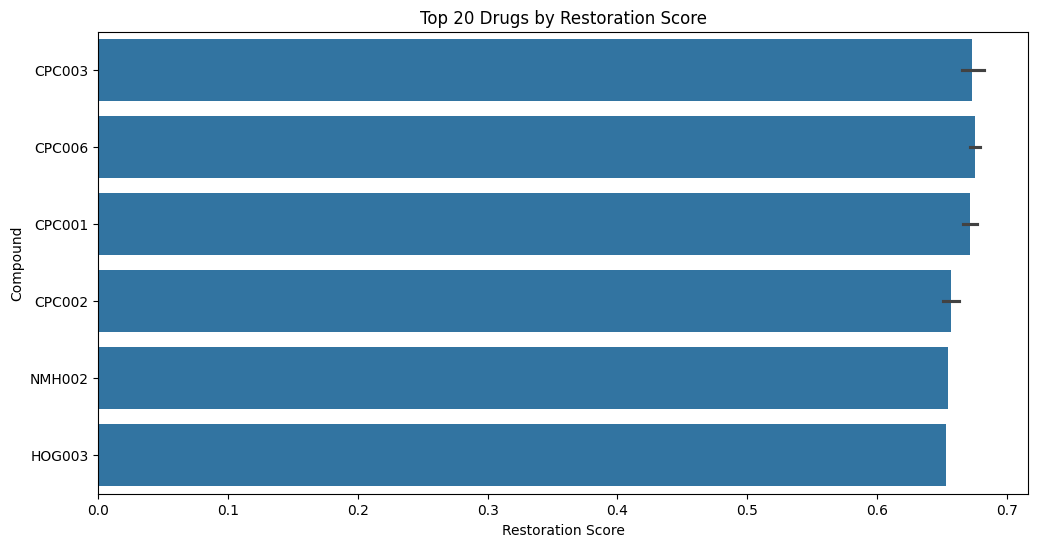

In [17]:
top20 = top_drugs.head(20)

plt.figure(figsize=(12,6))
sns.barplot(
    x='RestorationScore',
    y='Compound',
    data=top20
)
plt.xlabel("Restoration Score")
plt.ylabel("Compound")
plt.title("Top 20 Drugs by Restoration Score")
plt.show()

